# Diversity Evaluation

This notebook evaluates ranking and reranking results based on diversity. The results are computed for the top 10 and top 100 results.
It will:
- compute the diversity scores for ranking and rerankings
- compute diversity statistics, such as mean, standard deviation, median, minimum and maximum
- plot histograms of the diversity scores for ranking and rerankings
- compare ranking and rerankings on reranking being equal or better
- compute the statistical validity of the reranking compared to the ranking




# Imports

In [85]:
import numpy as np
import pandas as pd
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind
import seaborn as sns
sns.set()
sns.set_theme(style="whitegrid")

# Mount google drive to get data
(just for Marit)

In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive');
os.chdir('gdrive/My Drive/Information Retrieval/Information Retrieval Project/Notebooks')
os.listdir()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['.ipynb_checkpoints',
 'Unused - Create query topic dataset.ipynb',
 'lda_weights (1)',
 'lda_weights',
 'Deprecated files',
 'LDA_wordclouds',
 'Create ranking datasets (BM25F and BM25).ipynb',
 'MeSH - Document Topics Downloader.ipynb',
 'LDA_wordcloud.ipynb',
 'Create ranking datasets BM25.ipynb',
 'Evaluation-Diversity-Total.ipynb',
 'DiversificationAlgorithm.ipynb',
 'Analyse LDA group datasets from preprocessed datasets.ipynb',
 'Evaluation-TREC-create files and analyse.ipynb',
 'Evaluation-Diversity.ipynb']

# Diversity algorithm

In [4]:
def computeDiversity(docs):
    n = len(docs)
    diversity = [(1-jaccard_similarity(doc_i, doc_j)) for i, doc_i in enumerate(docs)
                                                      for doc_j in docs[i:n]]
    diversity = sum(diversity) / (n/2*(n-1))
    return diversity

# def computeSimilarity(docs):
#     n = len(docs)
#     similarity = [jaccard_similarity(doc_i, doc_j) for i, doc_i in enumerate(docs)
#                                                   for doc_j in docs[i+1:n]]
#     similarity = sum(similarity) / (n/2*(n-1))
#     return similarity

def jaccard_similarity(listA, listB):
    if len(set(listA))==0 and len(set(listB))==0:
      return 1.0

    intersection = len(set(listA).intersection(listB))
    union = len(set(listA)) + len(set(listB)) - intersection
    return intersection / union

def computeDiversityFullDataset(dataset, med_topics, top_n = [100, 10]):
    for top in top_n:
        dataset[f'Diversity@{top}'] = None

    for query_id in tqdm(dataset.index.values):
        # compute diversity for all top n's
        for top in top_n:
            docs_topics = [med_topics.Topics.loc[doc] for doc in dataset.ranking.loc[query_id][:top]]
            diversity = computeDiversity(docs_topics)
            dataset[f'Diversity@{top}'].loc[query_id] = diversity

    return dataset


# Load in topics

In [5]:
med_topics = pd.read_csv("../Data/clean/med_documents.csv", index_col=0, header=0)
med_topics.Topics = med_topics.Topics.apply(eval)

med_topics

,Topics
index,
MED-1,"[acrylamide / blood, adult, birth weight, chro..."
MED-2,"[acrylamide / chemistry, acrylamide / toxicity..."
MED-3,"[acrylamide / administration &amp; dosage, acr..."
MED-4,"[adult, aged, breast neoplasms / etiology, bre..."
MED-5,"[adult, aged, aged, 80 and over, body mass ind..."
...,...
MED-5367,"[aged, aged, 80 and over, carotenoids / blood,..."
MED-5368,"[animals, cohort studies, diet, fatty acids, o..."
MED-5369,"[adolescent, adult, cause of death / trends, c..."


# Evaluate BM25
## Load in BM25 data


Evaluate diversity of BM25 data


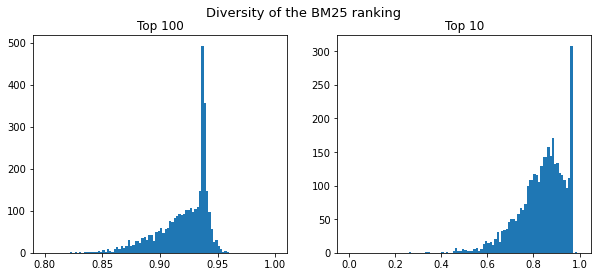

In [9]:
n_bins = 100

print(f"\nEvaluate diversity of BM25 data")

####################### Set path for BM25 data #######################
BM25_path = f"../Data/results/ranking.bm25.csv"
# Load in data
BM25_ranking = pd.read_csv(BM25_path, sep=',', index_col=0, header=0 )
BM25_ranking.ranking = BM25_ranking.ranking.apply(eval)
BM25_ranking.scores  = BM25_ranking.scores.apply(eval)

# Compute diversity if it is not known yet
if 'Diversity@100' not in BM25_ranking.columns:
    # Compute diversity
    computeDiversityFullDataset(BM25_ranking, med_topics)
    # Save diversity to file
    BM25_ranking.to_csv(BM25_path)

# Plot some results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f'Diversity of the BM25 ranking', fontsize=13)

axs[0].hist(BM25_ranking['Diversity@100'], range=(0.8, 1), bins = n_bins)
axs[0].set_title("Top 100")

axs[1].hist(BM25_ranking['Diversity@10'], range=(0, 1), bins = n_bins)
axs[1].set_title("Top 10")
plt.show()

# Evaluatate rerankings
## Test all the epsilon values for SPC and DIC



	Evaluating SPC fairness contraint rerankings
Evaluating e=0
Evaluating e=0.01
Evaluating e=0.1
Evaluating e=0.25
Evaluating e=0.5
Evaluating e=0.75
Evaluating e=0.9
Evaluating e=0.99
Evaluating e=1


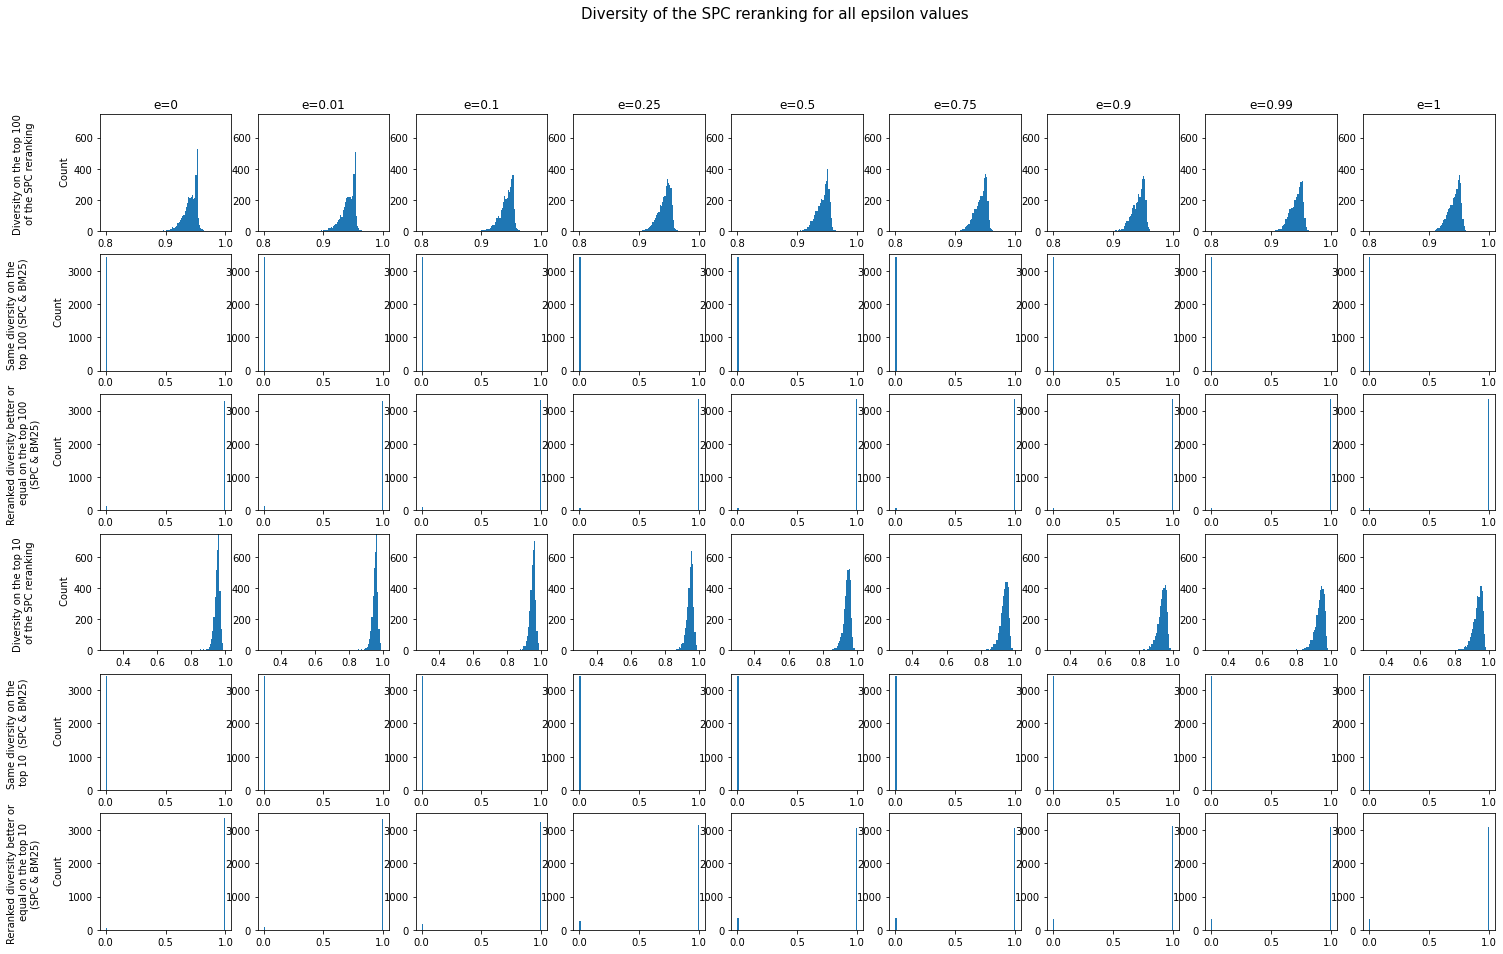

The diversity statistics for SPC are the following:


,mean-Top100,standardDeviation-Top100,median-Top100,min-Top100,max-Top100,mean-Top10,standardDeviation-Top10,median-Top10,min-Top10,max-Top10
Epsilon,,,,,,,,,,
BM25,0.920849,0.0220232,0.927785,0.822169,0.958204,0.835386,0.0992313,0.852675,0.269732,0.980392
0,0.941618,0.0112486,0.943851,0.886879,0.964695,0.95147,0.0173529,0.954647,0.789205,0.986544
0.01,0.941655,0.011207,0.943789,0.886879,0.964695,0.951297,0.0173541,0.954427,0.789205,0.986544
0.1,0.941802,0.0107939,0.944051,0.891401,0.963045,0.949619,0.0174029,0.952072,0.817662,0.986544
0.25,0.942145,0.0101975,0.944376,0.897256,0.964189,0.946473,0.0189044,0.949944,0.827334,0.985638
0.5,0.942614,0.0101085,0.944979,0.90207,0.964836,0.941596,0.0212765,0.945299,0.83898,0.987128
0.75,0.942859,0.0100009,0.945059,0.897287,0.963592,0.937847,0.0245408,0.942031,0.804227,0.986925
0.9,0.94266,0.0101245,0.944801,0.903216,0.964676,0.936942,0.0263975,0.941837,0.78403,0.986877
0.99,0.942563,0.0100266,0.944654,0.90526,0.963798,0.935261,0.0280777,0.940574,0.709199,0.987524


The significance results for SPC are the following:


,s-Top100-wilcoxon-equal,p-Top100-wilcoxon-equal,s-Top100-wilcoxon-greater,p-Top100-wilcoxon-greater,s-Top100-ttest,p-Top100-ttest,s-Top10-wilcoxon-equal,p-Top10-wilcoxon-equal,s-Top10-wilcoxon-greater,p-Top10-wilcoxon-greater,s-Top10-ttest,p-Top10-ttest
Epsilon,,,,,,,,,,,,
0.00,32255,0,5.81424e+06,0,49.1008,0,24054,0,5.82244e+06,0,67.3702,0
0.01,30176,0,5.81631e+06,0,49.2245,0,28871,0,5.81762e+06,0,67.2701,0
0.10,20773,0,5.82572e+06,0,49.9459,0,56975,0,5.78952e+06,0,66.2906,0
0.25,14752,0,5.83174e+06,0,51.3002,0,89090,0,5.7574e+06,0,64.2927,0
0.50,9903,0,5.83659e+06,0,52.5116,0,127547,0,5.71894e+06,0,61.1848,0
0.75,7247,0,5.83924e+06,0,53.1999,0,143592,0,5.7029e+06,0,58.6012,0
0.90,9153,0,5.83734e+06,0,52.6065,0,117488,0,5.729e+06,0,57.8225,0
0.99,10040,0,5.83645e+06,0,52.4615,0,144191,0,5.7023e+06,0,56.6202,0
1.00,12285,0,5.83420e+06,0,52.5429,0,140670,0,5.70582e+06,0,56.547,0



	Evaluating DIC fairness contraint rerankings
Evaluating e=0
Evaluating e=0.01
Evaluating e=0.1
Evaluating e=0.25
Evaluating e=0.5
Evaluating e=0.75
Evaluating e=0.9
Evaluating e=0.99
Evaluating e=1


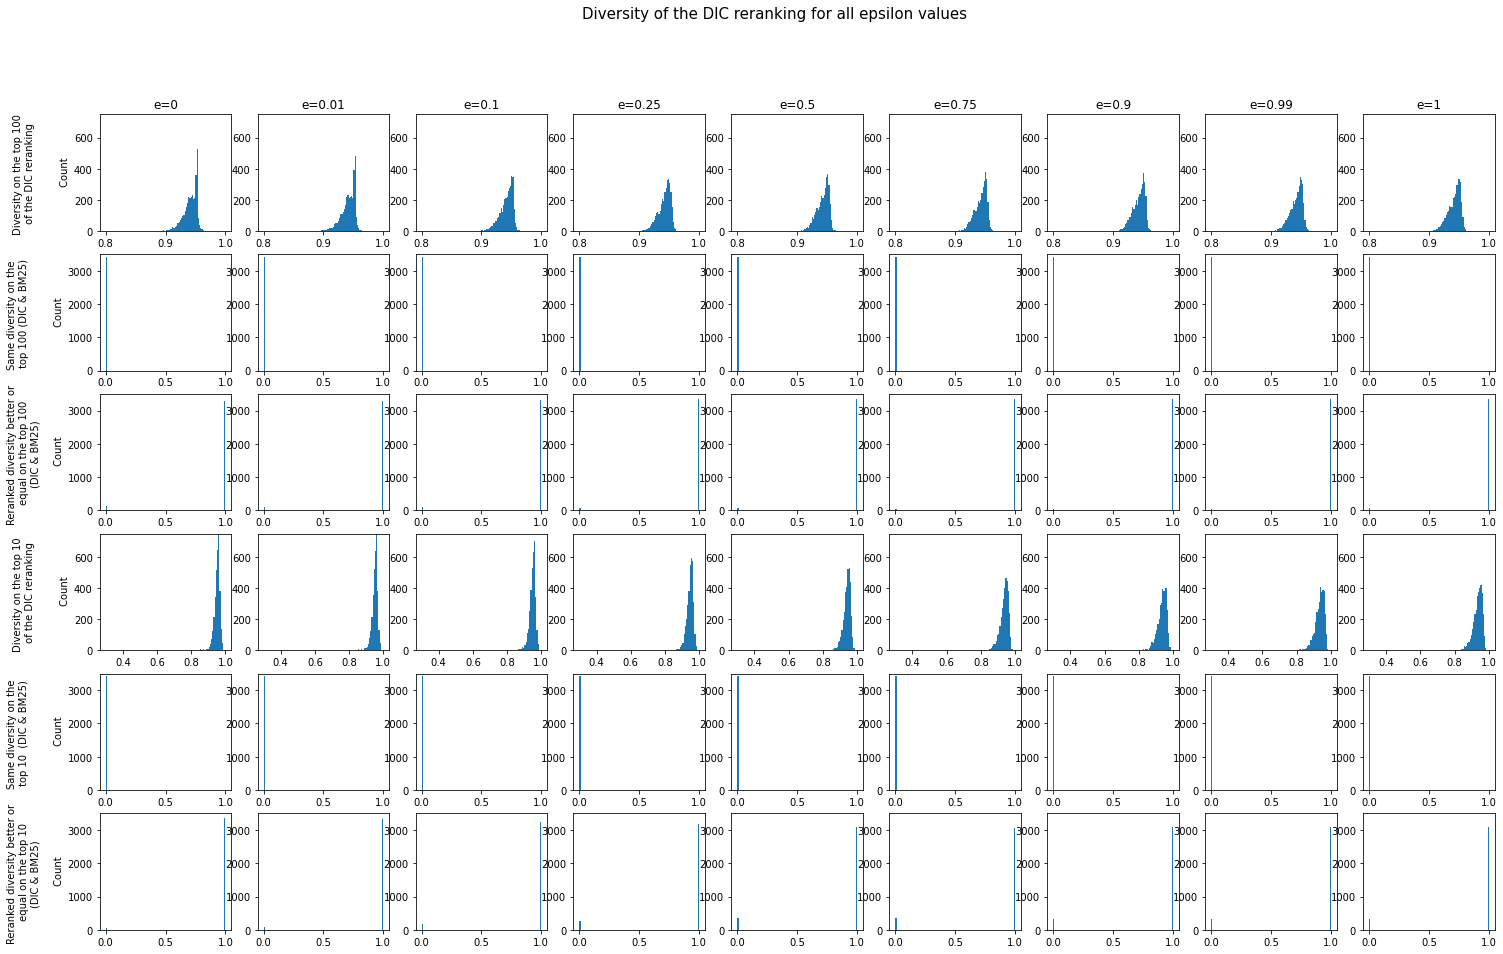

The diversity statistics for DIC are the following:


,mean-Top100,standardDeviation-Top100,median-Top100,min-Top100,max-Top100,mean-Top10,standardDeviation-Top10,median-Top10,min-Top10,max-Top10
Epsilon,,,,,,,,,,
BM25,0.920849,0.0220232,0.927785,0.822169,0.958204,0.835386,0.0992313,0.852675,0.269732,0.980392
0,0.941618,0.0112486,0.943851,0.886879,0.964695,0.95147,0.0173529,0.954647,0.789205,0.986544
0.01,0.941648,0.0111668,0.94387,0.889391,0.964695,0.951321,0.017288,0.954412,0.789205,0.986544
0.1,0.941879,0.0107478,0.944357,0.892249,0.964811,0.949542,0.0177075,0.952302,0.805894,0.986544
0.25,0.942013,0.0101206,0.944274,0.901102,0.965122,0.946732,0.0184095,0.949887,0.827334,0.98402
0.5,0.942589,0.010045,0.94486,0.898769,0.964558,0.941478,0.0210889,0.945551,0.797365,0.983267
0.75,0.942876,0.0100015,0.945307,0.906071,0.964204,0.93806,0.0245909,0.942827,0.814706,0.98444
0.9,0.942799,0.0101149,0.945156,0.899881,0.964906,0.937123,0.0266116,0.942109,0.768837,0.989519
0.99,0.942546,0.010101,0.944727,0.902209,0.965497,0.935088,0.0278376,0.940315,0.755555,0.985314


The significance results for DIC are the following:


,s-Top100-wilcoxon-equal,p-Top100-wilcoxon-equal,s-Top100-wilcoxon-greater,p-Top100-wilcoxon-greater,s-Top100-ttest,p-Top100-ttest,s-Top10-wilcoxon-equal,p-Top10-wilcoxon-equal,s-Top10-wilcoxon-greater,p-Top10-wilcoxon-greater,s-Top10-ttest,p-Top10-ttest
Epsilon,,,,,,,,,,,,
0.00,32255,0,5.81424e+06,0,49.1008,0,24054,0,5.82244e+06,0,67.3702,0
0.01,31222,0,5.81527e+06,0,49.2441,0,27822,0,5.81867e+06,0,67.2912,0
0.10,18251,0,5.82824e+06,0,50.1716,0,59855,0,5.78664e+06,0,66.211,0
0.25,16693,0,5.8298e+06,0,51.05,0,83710,0,5.76278e+06,0,64.5008,0
0.50,11020,0,5.83547e+06,0,52.5084,0,125136,0,5.72135e+06,0,61.1401,0
0.75,8002,0,5.83849e+06,0,53.241,0,135852,0,5.71064e+06,0,58.7159,0
0.90,8757,0,5.83773e+06,0,52.9516,0,122233,0,5.72426e+06,0,57.894,0
0.99,9208,0,5.83728e+06,0,52.3546,0,138597,0,5.70789e+06,0,56.5577,0
1.00,9211,0,5.83728e+06,0,52.6394,0,137559,0,5.70893e+06,0,57.0865,0


In [68]:
# Specify the fairness constraint types
types   = ['spc', 'dic']
# Specify the epsilon values
epsilon = [0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1]

n_bins = 100

# Reading BM25 ranking in
BM25_ranking = pd.read_csv(f"../Data/results/ranking.bm25.csv", sep=',', index_col=0, header=0 )
BM25_ranking.ranking = BM25_ranking.ranking.apply(eval)
BM25_ranking.scores  = BM25_ranking.scores.apply(eval)

# Loop over fairness constraint types
for t in types:
    print(f"\n\tEvaluating {t.upper()} fairness contraint rerankings")

    # Initialize plot with general information
    fig, axs = plt.subplots(6, len(epsilon), figsize=(25,15))
    fig.suptitle(f'Diversity of the {t.upper()} reranking for all epsilon values', fontsize=15)
    
    # Initialize table to store diversity results
    columns = ["mean-Top100", "standardDeviation-Top100", "median-Top100", "min-Top100", "max-Top100",
              "mean-Top10",  "standardDeviation-Top10",  "median-Top10",  "min-Top10",  "max-Top10"]
    diversity_table = pd.DataFrame(index=['BM25']+epsilon, columns=columns)
    diversity_table.index.name = "Epsilon"
    # Add diversity statistics for BM25
    diversity_table['mean-Top100'][['BM25']]              = np.mean(BM25_ranking['Diversity@100'])
    diversity_table['mean-Top100'][['BM25']]              = np.mean(BM25_ranking['Diversity@100'])
    diversity_table['standardDeviation-Top100'][['BM25']] = np.std(BM25_ranking['Diversity@100'])
    diversity_table['median-Top100'][['BM25']]            = np.median(BM25_ranking['Diversity@100'])
    diversity_table['min-Top100'][['BM25']]               = np.min(BM25_ranking['Diversity@100'])
    diversity_table['max-Top100'][['BM25']]               = np.max(BM25_ranking['Diversity@100'])
    diversity_table['mean-Top10'][['BM25']]               = np.mean(BM25_ranking['Diversity@10'])
    diversity_table['standardDeviation-Top10'][['BM25']]  = np.std(BM25_ranking['Diversity@10'])
    diversity_table['median-Top10'][['BM25']]             = np.median(BM25_ranking['Diversity@10'])
    diversity_table['min-Top10'][['BM25']]                = np.min(BM25_ranking['Diversity@10'])
    diversity_table['max-Top10'][['BM25']]                = np.max(BM25_ranking['Diversity@10'])

    # Initialize table to store significance results
    columns = ["s-Top100-wilcoxon-equal",   "p-Top100-wilcoxon-equal",
              "s-Top100-wilcoxon-greater", "p-Top100-wilcoxon-greater",
              "s-Top100-ttest",            "p-Top100-ttest",
              "s-Top10-wilcoxon-equal",    "p-Top10-wilcoxon-equal",
              "s-Top10-wilcoxon-greater",  "p-Top10-wilcoxon-greater",
              "s-Top10-ttest",             "p-Top10-ttest",]
    significance_table = pd.DataFrame(index=epsilon, columns=columns)
    significance_table.index.name = "Epsilon"

    for i, e in enumerate(epsilon):
        print(f"Evaluating e={e}")

        ####################### Set path for reranking data #######################
        data_path_100     = f"../Data/results/{t}/reranking.top100.{t}.e{e}.train.csv"
        data_path_10      = f"../Data/results/{t}/reranking.top10.{t}.e{e}.train.csv"
        significance_path = f"../Data/results/{t}/significance.{t}.csv"
        diversity_path    = f"../Data/results/{t}/diversity.{t}.csv"

        # Load in data
        reranking_ranking_100         = pd.read_csv(data_path_100, sep=',', index_col=0, header=0 )
        reranking_ranking_100.ranking = reranking_ranking_100.ranking.apply(eval)
        reranking_ranking_100.scores  = reranking_ranking_100.scores.apply(eval)
        reranking_ranking_10          = pd.read_csv(data_path_10, sep=',', index_col=0, header=0 )
        reranking_ranking_10.ranking  = reranking_ranking_10.ranking.apply(eval)
        reranking_ranking_10.scores   = reranking_ranking_10.scores.apply(eval)            

        # Compute diversity
        if 'Diversity@100' not in reranking_ranking_100.columns:
            reranking_ranking_100 = computeDiversityFullDataset(reranking_ranking_100, med_topics, top_n=[100])
            reranking_ranking_100.to_csv(data_path_100)
        if 'Diversity@10' not in reranking_ranking_10.columns:
            reranking_ranking_10 = computeDiversityFullDataset(reranking_ranking_10, med_topics, top_n=[10])
            reranking_ranking_10.to_csv(data_path_10)

        # Compute some diversity statistics
        diversity_table['mean-Top100'][[e]]              = np.mean(reranking_ranking_100['Diversity@100'])
        diversity_table['standardDeviation-Top100'][[e]] = np.std(reranking_ranking_100['Diversity@100'])
        diversity_table['median-Top100'][[e]]            = np.median(reranking_ranking_100['Diversity@100'])
        diversity_table['min-Top100'][[e]]               = np.min(reranking_ranking_100['Diversity@100'])
        diversity_table['max-Top100'][[e]]               = np.max(reranking_ranking_100['Diversity@100'])
        diversity_table['mean-Top10'][[e]]               = np.mean(reranking_ranking_10['Diversity@10'])
        diversity_table['standardDeviation-Top10'][[e]]  = np.std(reranking_ranking_10['Diversity@10'])
        diversity_table['median-Top10'][[e]]             = np.median(reranking_ranking_10['Diversity@10'])
        diversity_table['min-Top10'][[e]]                = np.min(reranking_ranking_10['Diversity@10'])
        diversity_table['max-Top10'][[e]]                = np.max(reranking_ranking_10['Diversity@10'])

        # Plot some results
        axs[0,i].set(title=f'e={e}')
        axs[0,i].hist(reranking_ranking_100['Diversity@100'], range=(0.8, 1), bins = n_bins)
        axs[0,i].set_ylim([0, 750])
        
        axs[1,i].hist((reranking_ranking_100['Diversity@100']==BM25_ranking['Diversity@100']).astype(int), range=(0, 1), bins = n_bins)
        axs[1,i].set_ylim([0, 3500])

        axs[2,i].hist((reranking_ranking_100['Diversity@100']>=BM25_ranking['Diversity@100']).astype(int), range=(0, 1), bins = n_bins)
        axs[2,i].set_ylim([0, 3500])

        axs[3,i].hist(reranking_ranking_10['Diversity@10'], range=(0.3, 1), bins = n_bins)
        axs[3,i].set_ylim([0, 750])

        axs[4,i].hist((reranking_ranking_10['Diversity@10']==BM25_ranking['Diversity@10']).astype(int),   range=(0, 1), bins = n_bins)
        axs[4,i].set_ylim([0, 3500])

        axs[5,i].hist((reranking_ranking_10['Diversity@10']>=BM25_ranking['Diversity@10']).astype(int), range=(0, 1), bins = n_bins)
        axs[5,i].set_ylim([0, 3500])

        # Compute significance Wilcoxon      (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)
        significance_table['s-Top100-wilcoxon-equal'][[e]],   significance_table['p-Top100-wilcoxon-equal'][[e]]   = \
                  wilcoxon(reranking_ranking_100['Diversity@100'], BM25_ranking['Diversity@100'], zero_method='zsplit')
        significance_table['s-Top100-wilcoxon-greater'][[e]], significance_table['p-Top100-wilcoxon-greater'][[e]] = \
                  wilcoxon(reranking_ranking_100['Diversity@100'], BM25_ranking['Diversity@100'], zero_method='zsplit', alternative='greater')
        significance_table['s-Top10-wilcoxon-equal'][[e]],    significance_table['p-Top10-wilcoxon-equal'][[e]]    = \
                  wilcoxon(reranking_ranking_10['Diversity@10'],  BM25_ranking['Diversity@10'],  zero_method='zsplit')
        significance_table['s-Top10-wilcoxon-greater'][[e]],  significance_table['p-Top10-wilcoxon-greater'][[e]]  = \
                  wilcoxon(reranking_ranking_10['Diversity@10'],  BM25_ranking['Diversity@10'],  zero_method='zsplit', alternative='greater')
        
        # Compute significance t-test        (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
        significance_table['s-Top100-ttest'][[e]],            significance_table['p-Top100-ttest'][[e]]            = \
                  ttest_ind(reranking_ranking_100['Diversity@100'], BM25_ranking['Diversity@100'])
        significance_table['s-Top10-ttest'][[e]],             significance_table['p-Top10-ttest'][[e]]             = \
                  ttest_ind(reranking_ranking_10['Diversity@10'],  BM25_ranking['Diversity@10'])
    
    axs[0,0].set_ylabel(f"Diversity on the top 100 \n of the {t.upper()} reranking \n\n\n Count")
    axs[1,0].set_ylabel(f"Same diversity on the \n top 100 ({t.upper()} & BM25) \n\n\n Count")
    axs[2,0].set_ylabel(f"Reranked diversity better or \n equal on the top 100 \n({t.upper()} & BM25) \n\n Count")
    axs[3,0].set_ylabel(f"Diversity on the top 10 \n of the {t.upper()} reranking \n\n\n Count")
    axs[4,0].set_ylabel(f"Same diversity on the \n top 10  ({t.upper()} & BM25) \n\n\n Count")
    axs[5,0].set_ylabel(f"Reranked diversity better or \n equal on the top 10 \n({t.upper()} & BM25) \n\n Count")

    plt.show()

    print(f"The diversity statistics for {t.upper()} are the following:")
    display(diversity_table)
    # Save diversity statistics table
    diversity_table.to_csv(diversity_path)

    print(f"The significance results for {t.upper()} are the following:")
    display(significance_table)
    # Save significance table
    significance_table.to_csv(significance_path)
        

## Plot diverisity values as Boxplot with BM25

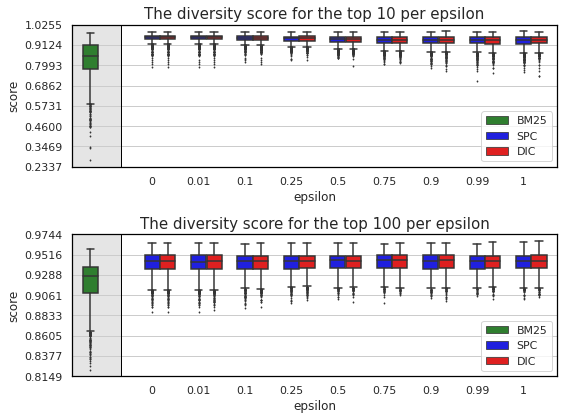

In [109]:
# Specify the fairness constraint types
types   = ['spc', 'dic']
# Specify the fairness constraint types
top_n   = [10, 100]
# Specify the epsilon values
epsilon = [0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1]

# Initialize plot with general information
fig, axs = plt.subplots(len(top_n), 1)
fig.set_size_inches(8, 6)

# Load in BM25 data
BM25_ranking = pd.read_csv(f"../Data/results/ranking.bm25.csv", sep=',', index_col=0, header=0 )
BM25_ranking.ranking = BM25_ranking.ranking.apply(eval)
BM25_ranking.scores  = BM25_ranking.scores.apply(eval)
BM25_ranking = BM25_ranking.reset_index(drop=True)

# Set colors for different types
graph_colors = {
    'SPC':  'blue',
    'DIC':  'red',
    'BM25': 'forestgreen',
}

# Loop over fairness constraint types
for i, top in enumerate(top_n):
    columns = ['score', 'epsilon', 'type']
    diversity_scores = pd.DataFrame(columns=columns)

    # Reformat data
    BM25 = pd.DataFrame(data=BM25_ranking[f'Diversity@{top}'])
    BM25.columns = ['score']
    BM25['epsilon'] = 'BM25'
    BM25['type']    = 'BM25'
    # Add data to diversity_scores
    diversity_scores = diversity_scores.append(BM25)

    # Get the data
    for t in types:
        for e in epsilon:
            ####################### Set path for reranking data #######################
            data_path     = f"../Data/results/{t}/reranking.top{top}.{t}.e{e}.train.csv"

            # Load in data
            data         = pd.read_csv(data_path, sep=',', index_col=0, header=0 )
            data.ranking = data.ranking.apply(eval)
            data.scores  = data.scores.apply(eval)

            # Reformat data
            data = data.reset_index(drop=True)
            data = data.drop(columns=['ranking', 'scores'])
            data.columns = ['score']
            data['epsilon'] = e
            data['type']    = t.upper()

            # Add data to diversity_scores
            diversity_scores = diversity_scores.append(data)
    
    # Make the beautiful plot
    axs[i].spines['bottom'].set_color('0')
    axs[i].spines['top'].set_color('0')
    axs[i].spines['right'].set_color('0')
    axs[i].spines['left'].set_color('0')
    axs[i].axvline(x=-0.2, ymin=0, ymax=1, color='black', alpha=0.1, linewidth=50, zorder=0)  # Gray box
    axs[i].axvline(x=0.33, ymin=0, ymax=1, color='black', linewidth=1, zorder=1)              # Black line
    sns.boxplot(ax=axs[i], x="epsilon", y="score", hue="type",
                    data=diversity_scores, palette=graph_colors, fliersize=1, width=1)
    axs[i].set_title(f'The diversity score for the top {top} per epsilon', fontsize=15)
    axs[i].set_xticks(range(1+len(epsilon)))
    axs[i].set_xticklabels(['']+epsilon)
    axs[i].margins(x=-0.01)
    axs[i].set_xlabel('epsilon')
    start, end = axs[i].get_ylim()
    axs[i].yaxis.set_ticks(np.linspace(start, end, 8))
    axs[i].set_ylabel('score')
    axs[i].legend(loc='lower right')
    axs[i].get_legend().set_title('')

plt.tight_layout()
plt.show()

## Plot diverisity values as Boxplot without BM25

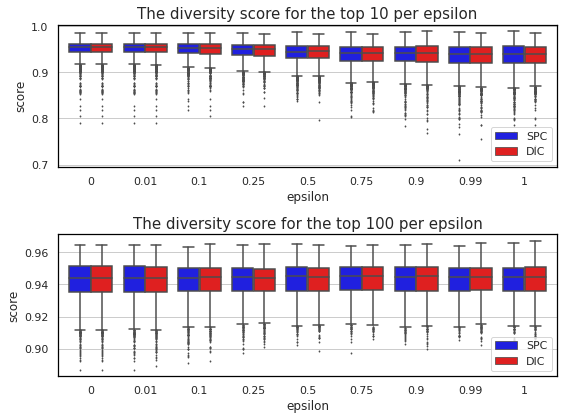

In [110]:
# Specify the fairness constraint types
types   = ['spc', 'dic']
# Specify the fairness constraint types
top_n   = [10, 100]
# Specify the epsilon values
epsilon = [0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1]

# Initialize plot with general information
fig, axs = plt.subplots(len(top_n), 1)
fig.set_size_inches(8, 6)

# Set colors for different types
graph_colors = {
    'SPC':  'blue',
    'DIC':  'red',
    'BM25': 'forestgreen',
}

# Loop over fairness constraint types
for i, top in enumerate(top_n):
    columns = ['score', 'epsilon', 'type']
    diversity_scores = pd.DataFrame(columns=columns)

    # Get the data
    for t in types:
        for e in epsilon:
            ####################### Set path for reranking data #######################
            data_path     = f"../Data/results/{t}/reranking.top{top}.{t}.e{e}.train.csv"

            # Load in data
            data         = pd.read_csv(data_path, sep=',', index_col=0, header=0 )
            data.ranking = data.ranking.apply(eval)
            data.scores  = data.scores.apply(eval)

            # Reformat data
            data = data.reset_index(drop=True)
            data = data.drop(columns=['ranking', 'scores'])
            data.columns = ['score']
            data['epsilon'] = e
            data['type']    = t.upper()

            # Add data to diversity_scores
            diversity_scores = diversity_scores.append(data)
    
    # Make the beautiful plot
    axs[i].spines['bottom'].set_color('0')
    axs[i].spines['top'].set_color('0')
    axs[i].spines['right'].set_color('0')
    axs[i].spines['left'].set_color('0')
    sns.boxplot(ax=axs[i], x="epsilon", y="score", hue="type",
                    data=diversity_scores, palette=graph_colors, fliersize=1)
    axs[i].set_title(f'The diversity score for the top {top} per epsilon', fontsize=15)
    axs[i].set_xticks(range(len(epsilon)))
    axs[i].set_xticklabels(epsilon)
    axs[i].margins(x=-0.01)
    axs[i].set_xlabel('epsilon')
    axs[i].set_ylabel('score')
    axs[i].legend(loc='lower right')
    axs[i].get_legend().set_title('')

plt.tight_layout()
plt.show()